# Intro

So you need to build a table model? 3ML via astromodels provides you with nice
facilities to accomplish this task. But often, we need to interface with
computationally expensive simulations and require many runs of these
simulations. This is a very generic task and Ron Swanson wants to make things as
simple as possible for you. Making things complicated is annoying.

![alt text](https://raw.githubusercontent.com/grburgess/ronswanson/master/docs/media/mad.jpg)

## Example with a Band function

Let's say we want to make a table model from a Band function.

We pick a parameter grid and a grid of energies for our simulation. We can enter
these in a YAML file:

```yaml
alpha:
  custom: no
  vmin: -1
  vmax: 0
  scale: "linear"
  n_points: 10

beta:
  custom: no
  vmin: -3
  vmax: -2
  scale: "linear"
  n_points: 10

epeak:
  custom: yes
  values: [50., 69.74 , 97.29, 135.72, 189.32, 264.097, 368.4, 513.9, 716.87, 1000.]

energy_grid:
  custom: no
  vmin: 10
  vmax: 1000
  scale: "log"
  n_points: 50


```

As can be seen, we can specify the parameter/energy grids ourselves, or we can
specify their ranges and let it be done for us.

It is possible that a simulation outputs more than one type of array (photons,
electrons, neutrinos, etc.). In this case, each output may have its own energy
grid. These can be specified as ```energy_grid_0```,
```energy_grid_1```...```energy_grid_n```. More on how to grab the output from
these below.





### The Simulation class

Now we need to make a class for the simulation. We will inherit from the
simulation class and specify a `_run_call` function that tells the program how
to run the simulation for a given set of parameters. This function **must**
return a dictionary of arrays of photon / particle fluxes for the given
energies. The keys of the dictionary should be ```output_0```,
```output_1```...```output_n``` for each type of output corresponding to the
energy grids above.



```python
from typing import Dict

import numpy as np
from astromodels import Band
import ronswanson as dukesilver


class BandSimulation(dukesilver.Simulation):
    def __init__(
        self,
        simulation_id: int,
        parameter_set: Dict[str, float],
        energy_grid: np.ndarray,
        out_file: str,
    ) -> None:
        super().__init__(simulation_id, parameter_set, energy_grid, out_file)

    def _run_call(self) -> np.ndarray:

        b = Band(
            K=1,
            alpha=self._parameter_set["alpha"],
            beta=self._parameter_set["beta"],
            xp=self._parameter_set["epeak"],
        )

        return dict(output_0=b(self._energy_grid))

```

### The Simulation Builder

Now we need to tell the simulation builder a few things so it can construct our
files for us. We have stored this YAML file in the repo itself. You should use
your own!

The `SimulationBuilder` class takes a parameter grid, the name of the file that
will be created, the import line for the custom simulation class, the number of
cores and nodes to execute on.

We configure this with a YAML file.

```yaml
# the import line to get our simulation
# we ALWAYS import as Simulation
import_line: "from ronswanson.band_simulation import BandSimulation as Simulation"

# the parameter grid
parameter_grid: "test_params.yml"

# name of our database
out_file: database.h5

# clean out the simulation directory after
# the run. It is defaulted to yes
clean: yes

simulation:

  # number of multi-process jobs
  n_mp_jobs: 8




```

In [1]:
import ronswanson

sb = ronswanson.SimulationBuilder.from_yaml("sim_build.yml")

06:26:52 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=585739;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=32753;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=381688;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=166917;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

06:26:53 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=622284;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=230821;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=356191;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=415820;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=96726;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=704033;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=373057;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=705376;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=844948;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=141303;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=614473;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=869038;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=108902;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=645121;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/core/parameter.py#704\704]8;;\

Now a python file will be written to the disk which you can run to create your
simulation runs. we can have a look at the file.

```
from ronswanson.band_simulation import BandSimulation as Simulation
from joblib import Parallel, delayed
from ronswanson import ParameterGrid

pg = ParameterGrid.from_yaml('/Users/jburgess/coding/projects/ronswanson/parameters.yml')
def func(i):
	params = pg.at_index(i)
	simulation = Simulation(i, params, pg.energy_grid.grid,'/Users/jburgess/coding/projects/ronswanson/database.h5')
	simulation.run()

iteration = [i for i in range(0, pg.n_points)]

Parallel(n_jobs=8)(delayed(func)(i) for i in iteration)

```

<!-- #region --> Now this simply uses `joblib` to farm out the iterations over
the parameter combinations. If iterations are to also be divided across HPC
nodes, the python script will be modified and an associated `SLURM` script will
be generated.

#### SLURM and advanced options

Configuring for SLURM and SBATCH systems is similar, but there are a few more options. ```ronswanson``` will set up bash scripts that will submit jobs to complete the simulations and then gather them into a database.

Here is an example script:

```yaml

# the import line to get our simulation
# we ALWAYS import as Simulation
import_line: "from ronswanson.band_simulation import BandSimulation as Simulation"

# the parameter grid
parameter_grid: "test_params.yml"

# name of our database
out_file: database.h5

simulation:

  # number of multi-process jobs PER node
  n_mp_jobs: 9

  # number of cpus to request per node (leave room for threads)
  n_cores_per_node: 72

  # number of runs per node
  # here, the 9 mp jobs will take turns with these 500 runs
  run_per_node: 500

  # the switch to say we are performing SLURM job
  use_nodes: yes

  # optional maximum number of nodes to request
  # if more than this are required, multiple
  # submission scripts are generated
  max_nodes: 300

  # the max run time for each job in the array
  time:
    hrs: 10
    min: 30
    sec: 0

gather:

  # after the simulations run
  # you submit and MPI job that collects the simualtions

  # number of simulations to collect per MPI rank
  n_gather_per_core: 100

  # number of cpus per node
  n_cores_per_node: 70

  # maximum job time
  time:
    hrs: 1
    min: 0
    sec: 0

```


Additional configuration of SLURM jobs can be handle with the ```ronswanson``` configuration.

### The Database


Upon running the script, an HDF5 database of the runs is created which contains
all the information needed to build a table model in `3ML`.  <!-- #endregion -->

In [2]:
from ronswanson.utils.package_data import get_path_of_data_file
from ronswanson import Database

In [3]:
db = Database.from_file(get_path_of_data_file("test_database.h5"))
db.parameter_ranges

OrderedDict([('alpha', array([-1. , -0.5,  0. ,  0.5,  1. ], dtype=float32)),
             ('beta',
              array([-3.  , -2.75, -2.5 , -2.25, -2.  ], dtype=float32)),
             ('epeak',
              array([  50.   ,   69.74 ,   97.29 ,  135.72 ,  189.32 ,  264.097,
                      368.4  ,  513.9  ,  716.87 , 1000.   ], dtype=float32))])

Now we can use the database to construct and save a table model for `3ML`

In [4]:
table_model = db.to_3ml("my_model", "a new model for 3ML")
table_model

         WARNING   Energy unit is not a Quantity instance, so units has not been provided.    ]8;id=691236;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/template_model.py\template_model.py]8;;\:]8;id=33816;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/template_model.py#106\106]8;;\
                  Using keV.                                                                                       

  0%|          | 0/250 [00:00<?, ?it/s]

* description: a new model for 3ML
  * formula: n.a.
  * parameters:
    * K:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * scale:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * alpha:
      * value: 0.0
      * desc: None
      * min_value: -1.0
      * max_value: 1.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * beta:
      * value: -2.5
      * desc: None
      * min_value: -3.0
      * max_value: -2.0
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true
    * epeak:
      * value: 226.70849609375
      * desc: None
      * min_value: 50.0
      * max_value: 1000.0
      * unit: ''
      * is_normalization: false
      * delta: 22.670849609375
      * free: true

In [5]:
import matplotlib.pyplot as plt
from astromodels import Band

%matplotlib inline

We can compare our table model with the Band function.

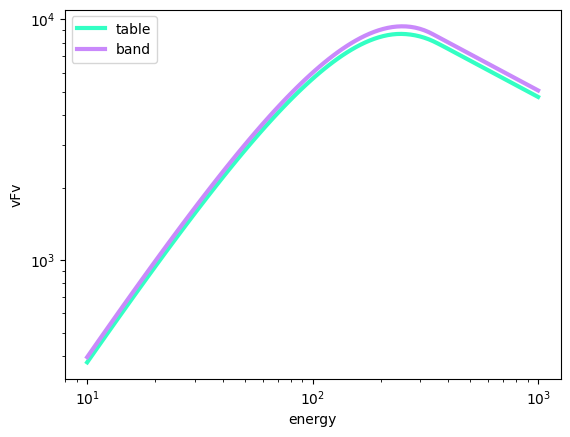

In [6]:
import numpy as np

ene = np.geomspace(10, 1000, 100)

b = Band()
b.alpha = -0.6
b.beta = -2.5
b.xp = 250
b.K = 1.05

table_model.alpha = -0.6
table_model.beta = -2.5
table_model.epeak = 250


fig, ax = plt.subplots()

ax.loglog(
    ene, ene**2 * table_model(ene), color='#33FFC4', lw=3, label="table"
)
ax.loglog(ene, ene**2 * b(ene), color='#C989FB', lw=3, label="band")

ax.set(xlabel="energy", ylabel="vFv")

ax.legend()

Great! That was way easier than programming everything yourself.

![alt text](https://raw.githubusercontent.com/grburgess/ronswanson/master/docs/media/happy.jpeg)


Suppose we did not want to use all the values in the parameter ranges we have simulated. Bigger interpolation tables take up memory when fitting.

We can select a subset of the parameter ranges when building the table

In [7]:
selection = {}
selection['alpha'] = dict(vmax=0)
selection['epeak'] = dict(vmin=200, vmax=700)

table_model_small = db.to_3ml(
    "my_model_small", "a new model for 3ML", **selection
)
table_model_small

06:26:57 WARNING   Energy unit is not a Quantity instance, so units has not been provided.    ]8;id=694431;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/template_model.py\template_model.py]8;;\:]8;id=922860;file:///opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/astromodels/functions/template_model.py#106\106]8;;\
                  Using keV.                                                                                       

  0%|          | 0/45 [00:00<?, ?it/s]

* description: a new model for 3ML
  * formula: n.a.
  * parameters:
    * K:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * scale:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * alpha:
      * value: -0.5
      * desc: None
      * min_value: -1.0
      * max_value: 0.0
      * unit: ''
      * is_normalization: false
      * delta: 0.05
      * free: true
    * beta:
      * value: -2.5
      * desc: None
      * min_value: -3.0
      * max_value: -2.0
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true
    * epeak:
      * value: 368.3999938964844
      * desc: None
      * min_value: 264.09698486328125
      * max_value: 513.9000244140625
      * unit: ''
      * is_normalization: false
      * delta: 36.83999938964844
      * free: true

Awesome! Now go enjoy your weekend.

![alt text](https://raw.githubusercontent.com/grburgess/ronswanson/master/docs/media/enjoy.jpg)

## User configuration

A simple YAML configuration is stored in ```~/.config/ronswanson/ronswanson_config.yml```. It allows for configuring the log as well as putting default SLURM configuration parameters.

An example:

```yaml

logging:
  'on': on
  level: INFO
slurm:

  # where to send SLURM emails
  user_email: my_email.com

  # modules to be loaded for MPI jobs (gather script)
  mpi_modules: ['intel/21.4.0', 'impi/2021.4',
  'anaconda/3/2021.11','hdf5-mpi/1.12.2', 'mpi4py/3.0.3', 'h5py-mpi/2.10']

  # modules to load for simulation jobs
  modules: ['intel/21.4.0', 'impi/2021.4', 'anaconda/3/2021.11','hdf5-serial/1.12.2']

  # the python binary for running the simulation jobs
  python: "python3"

  # where to store the simulations before
  # database creation (default will be the directory where the code is run)
  store_dir: /ptmp/jburgess

```

The configuration can be modified on the fly.

In [8]:
from ronswanson import ronswanson_config, show_configuration

In [9]:
show_configuration()

config
┣━━ logging
┃   ┣━━ on: True
┃   ┗━━ level: WARNING
┗━━ slurm
    ┣━━ user_email: user@email.com
    ┣━━ modules: None
    ┣━━ mpi_modules: None
    ┣━━ python: python
    ┗━━ store_dir: None

In [10]:
ronswanson_config.slurm.user_email

'user@email.com'

In [11]:
ronswanson_config.slurm.user_email = "workemail@email.com"

In [12]:
show_configuration()

config
┣━━ logging
┃   ┣━━ on: True
┃   ┗━━ level: WARNING
┗━━ slurm
    ┣━━ user_email: workemail@email.com
    ┣━━ modules: None
    ┣━━ mpi_modules: None
    ┣━━ python: python
    ┗━━ store_dir: None